# P8 : Name Identification Using Deep Networks
         Aitor Diaz de Otazu

The goal of the project is to solve the task of name transcription from handwritting images implementing a deep learning approach and using a database with a large number of images of handwritten names.

This notebook describes the implementation of CNN + RNN + CTC architecture for solve this task.

Link for download model and dataset: https://mega.nz/#!CLBW3CBb!WwCHdwM4kv7adoJ8IPeww_hTSm4fwLUuhEf-UIgB2Ic

NOTE: This implementation uses Tensorflow 1.12 !!!

In [1]:
import sys
import numpy as np
import tensorflow as tf
import os
import cv2
import pandas
import requests
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from io import BytesIO
import urllib.request
from time import time

from skimage.color import rgb2gray

/Users/aitor/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aitor/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aitor/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aitor/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: 

### Functions for preprocess the data and infer the results

In [2]:
#put ground truth texts into sparse tensor for ctc_loss
def toSparse(texts):
    indices = []
    values = []
    shape = [len(texts), 0] # last entry must be max(labelList[i])

    # go over all texts
    for (batchElement, text) in enumerate(texts):
        # convert to string of label (i.e. class-ids)
        #print(text)
        labelStr = [charList.index(c) for c in text]
      
        # sparse tensor must have size of max. label-string
        if len(labelStr) > shape[1]:
            shape[1] = len(labelStr)
        # put each label into sparse tensor
        for (i, label) in enumerate(labelStr):
            #print(label)
            indices.append([batchElement, i])
            values.append(label)

    return (indices, values, shape)

#Returns modified image with gaussian noise
def noisyImg(image):
    row,col= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.99
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    return noisy


#extract texts from output of CTC decoder
def decoderOutputToText(ctcOutput, batchSize):
    # contains string of labels for each batch element
    encodedLabelStrs = [[] for i in range(batchSize)]
    # word beam search: label strings terminated by blank 
    decoded=ctcOutput[0]

    # go over all indices and save mapping: batch -> values
    idxDict = { b : [] for b in range(batchSize) }
    for (idx, idx2d) in enumerate(decoded.indices):
        label = decoded.values[idx]
        batchElement = idx2d[0] # index according to [b,t]
        encodedLabelStrs[batchElement].append(label)

    # map labels to chars for all batch elements
    return [str().join([charList[c] for c in labelStr]) for labelStr in encodedLabelStrs]


def truncateLabel(text, maxTextLen):
    # ctc_loss can't compute loss if it cannot find a mapping between text label and input 
    # labels. Repeat letters cost double because of the blank symbol needing to be inserted.
    # If a too-long label is provided, ctc_loss returns an infinite gradient
    cost = 0
    for i in range(len(text)):
        if i != 0 and text[i] == text[i-1]:
            cost += 2
        else:
            cost += 1
        if cost > maxTextLen:
            return text[:i]
    return text
    
#Process the image for TF
def preprocess(img, imgSize):


    # create target image and copy sample image into it
    (wt, ht) = imgSize
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(img, newSize,interpolation = cv2.INTER_AREA)
    target = np.ones([ht, wt]) * 255
    target[0:newSize[1], 0:newSize[0]] = img

    # transpose for TF
    img = cv2.transpose(target)

    # normalize
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    return img

#Calculates accuracy based on how many characters has predicted correctly
def accuracy(real, prediction):
    char_num = np.array([len(x) for x in real]).sum()
    n_correct_char = 0
    
    for rn,pn in zip(real,prediction):
        for i in range(min(len(rn), len(pn))):
            if(rn[i] == pn[i]):
                n_correct_char +=1
                
    return n_correct_char/char_num
    




In [3]:
#Load the data from './HandwrittenNames-Dataset' folder

X_data = np.load('HandwrittenNames-Dataset/HandwrittenNames_data.npz',allow_pickle=True)['data']
Y_labels = np.load('HandwrittenNames-Dataset/HandwrittenNames_labels.npz',allow_pickle=True)['data']

In [4]:
#Processing imgs and creating more train data
x_train = []
y_train = []

for x,y in zip(X_data[:9000],Y_labels[:9000]):
    #Resize img for TF
    x = cv2.resize(x,(128,32),interpolation = cv2.INTER_AREA)
    y_train.append(truncateLabel(y,32))
    x_train.append(preprocess(x,(128,32)))
    y_train.append(truncateLabel(y,32))
    x_train.append(preprocess(noisyImg(x),(128,32)))

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = X_data[9000:]
y_test = Y_labels[9000:]

x_test_tf = []

for x in x_test :
    #Resize img for TF
    x = cv2.resize(x,(128,32),interpolation = cv2.INTER_AREA)
    x_test_tf.append(preprocess(x,(128,32)))

x_test_tf = np.array(x_test_tf)

In [5]:
print("Number of element for train:",x_train.shape[0])

print("Number of element for test:",x_test.shape[0])

Number of element for train: 18000
Number of element for test: 982


In [6]:
def next_batch(prev_batch, batch_size):
    return np.array(x_train[prev_batch:prev_batch + batch_size]), y_train[prev_batch:prev_batch + batch_size]

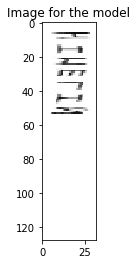

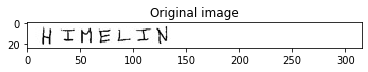

In [10]:
plt.title("Image for the model")
plt.imshow(x_train[0], cmap=plt.cm.gray)
plt.show()


plt.title("Original image")
plt.imshow(X_data[0], cmap=plt.cm.gray)
plt.show()


In [9]:

def predict(imgs):
    
    numBatchElements = len(imgs)
    evalList = [decoder] + ([])
    feedDict = {Input : imgs, seqLen : [32] * numBatchElements}
    evalRes = sess.run(evalList, feedDict)

    decoded = evalRes[0][0]
    #print(decoded)
    texts = decoderOutputToText(decoded, numBatchElements)
    
    return (texts)

In [10]:
# Model parameters



tf.reset_default_graph()




batchSize = 50
imgSize = (128, 32)
maxTextLen = 32
kernel_vals = [5, 5, 3, 3, 3]
feature_vals = [1, 32, 64, 64, 128, 256]
stride_vals = pool_vals = [(2,2), (2,2), (1,2), (1,2), (1,2)]

num_rnn_hiden = 256

charList = "ABCDEFGHIJKLMNOPQRSTUVWXYZ- "




#Input layer
Input = tf.placeholder(tf.float32, shape=(None, imgSize[0], imgSize[1]))

#CNN

cnnIn4d = tf.expand_dims(input=Input, axis=3)
print(cnnIn4d.shape)

kernel0 = tf.Variable(tf.truncated_normal([kernel_vals[0], kernel_vals[0],feature_vals[0], feature_vals[1]], stddev=0.1))
kernel1 = tf.Variable(tf.truncated_normal([kernel_vals[1], kernel_vals[1],feature_vals[1], feature_vals[2]], stddev=0.1))
kernel2 = tf.Variable(tf.truncated_normal([kernel_vals[2], kernel_vals[2],feature_vals[2], feature_vals[3]], stddev=0.1))
kernel3 = tf.Variable(tf.truncated_normal([kernel_vals[3], kernel_vals[3],feature_vals[3], feature_vals[4]], stddev=0.1))
kernel4 = tf.Variable(tf.truncated_normal([kernel_vals[4], kernel_vals[4],feature_vals[4], feature_vals[5]], stddev=0.1))

#First CNN layer
conv0 = tf.nn.conv2d(cnnIn4d, kernel0, padding='SAME',  strides=(1,1,1,1))
relu0 = tf.nn.relu(conv0)
pool0 = tf.nn.max_pool(relu0, (1, pool_vals[0][0], pool_vals[0][1], 1), 
                       (1, stride_vals[0][0], stride_vals[0][1], 1), 'VALID')

#Second CNN layer
conv1 = tf.nn.conv2d(pool0, kernel1, padding='SAME',  strides=(1,1,1,1))
relu1 = tf.nn.relu(conv1)
pool1 = tf.nn.max_pool(relu1, (1, pool_vals[1][0], pool_vals[1][1], 1), 
                       (1, stride_vals[1][0], stride_vals[1][1], 1), 'VALID')

#Third CNN layer
conv2 = tf.nn.conv2d(pool1, kernel2, padding='SAME',  strides=(1,1,1,1))
relu2 = tf.nn.relu(conv2)
pool2 = tf.nn.max_pool(relu2, (1, pool_vals[2][0], pool_vals[2][1], 1), 
                       (1, stride_vals[2][0], stride_vals[2][1], 1), 'VALID')

#Fourth CNN layer
conv3 = tf.nn.conv2d(pool2, kernel3, padding='SAME',  strides=(1,1,1,1))
relu3 = tf.nn.relu(conv3)
pool3 = tf.nn.max_pool(relu3, (1, pool_vals[3][0], pool_vals[3][1], 1), 
                       (1, stride_vals[3][0], stride_vals[3][1], 1), 'VALID')

#Fifth CNN layer
conv4 = tf.nn.conv2d(pool3, kernel4, padding='SAME',  strides=(1,1,1,1))
relu4 = tf.nn.relu(conv4)
pool4 = tf.nn.max_pool(relu4, (1, pool_vals[4][0], pool_vals[4][1], 1), 
                       (1, stride_vals[4][0], stride_vals[4][1], 1), 'VALID')
print(pool4.shape)


#RNN
rnnIn3d = tf.squeeze(pool4, axis=[2])

cells = [tf.contrib.rnn.LSTMCell(num_units=num_rnn_hiden, state_is_tuple=True) for _ in range(2)] # 2 layers

stacked = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=True) # stack basic cells

# bidirectional RNN

((fw, bw), _) = tf.nn.bidirectional_dynamic_rnn(cell_fw=stacked, 
                                               cell_bw=stacked, inputs=rnnIn3d, dtype=rnnIn3d.dtype)
concat = tf.expand_dims(tf.concat([fw, bw], 2), 2)

# project output to chars (including blank): BxTx1x2H -> BxTx1xC -> BxTxC
kernel = tf.Variable(tf.truncated_normal([1, 1, num_rnn_hiden * 2, len(charList) + 1], stddev=0.1))

rnnOut3d = tf.squeeze(tf.nn.atrous_conv2d(value=concat, filters=kernel, rate=1, padding='SAME'), axis=[2])
print(rnnIn3d)

#BTC
ctcIn3dTBC = tf.transpose(rnnOut3d, [1, 0, 2])
print(ctcIn3dTBC)
# ground truth text as sparse tensor
gtTexts = tf.SparseTensor(tf.placeholder(tf.int64, shape=[None, 2]) , tf.placeholder(tf.int32, [None]), tf.placeholder(tf.int64, [2]))

# calc loss for batch
seqLen = tf.placeholder(tf.int32, [None])
loss = tf.reduce_mean(tf.nn.ctc_loss(labels=gtTexts, inputs=ctcIn3dTBC, sequence_length=seqLen, ctc_merge_repeated=True))

# calc loss for each element to compute label probability
savedCtcInput = tf.placeholder(tf.float32, shape=[maxTextLen, None, len(charList) + 1])
lossPerElement = tf.nn.ctc_loss(labels=gtTexts, inputs=savedCtcInput, sequence_length=seqLen, ctc_merge_repeated=True)

decoder = tf.nn.ctc_beam_search_decoder(inputs=ctcIn3dTBC, sequence_length= seqLen , beam_width=50, merge_repeated=False)
print(decoder)

#Optimizer
learningRate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.RMSPropOptimizer(learningRate).minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

(?, 128, 32, 1)
(?, 32, 1, 256)
Tensor("Squeeze:0", shape=(?, 32, 256), dtype=float32)
Tensor("transpose:0", shape=(32, ?, 29), dtype=float32)
([<tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x1cb4fecfd0>], <tf.Tensor 'CTCBeamSearchDecoder:3' shape=(?, 1) dtype=float32>)


In [11]:
#LOAD TRAINED MODEL


sess = tf.Session()
latestSnapshot = tf.train.latest_checkpoint('./checkpoints')
saver.restore(sess, latestSnapshot)


INFO:tensorflow:Restoring parameters from ./checkpoints/HTRModel


### Training the model 

In [33]:

epoch = 20
batch_size = 50
prev_batch = 0

sess = tf.Session()

latestSnapshot = tf.train.latest_checkpoint('./checkpoints')

if latestSnapshot != None:
    saver.restore(sess, latestSnapshot)
else:
    sess.run(tf.global_variables_initializer())
    
t0 = time()

print("------------------ Training ------------------")
for ep in range(epoch):
    for i in range(len(x_train) // batch_size):
        t1 = time()
        X_batch, y_batch = next_batch(prev_batch, batch_size)
        prev_batch+=batch_size
        sparse = toSparse(y_batch)
        rate = 0.0001
        (_, lossVal) = sess.run([optimizer,loss], feed_dict={Input: X_batch, gtTexts : sparse, 
                                                             seqLen : [32] * batch_size,
                                                             learningRate : rate})
        if(i % 10 == 0):
            print("Epoch: ",ep,"Batch: ",i, "loss:", lossVal)  
        t2 = time()
    print("------------------ Epoch finished ------------------")
    print("Saving epoch",ep,"...")
    saver.save(sess, "./checkpoints/HTRModel")
    print("Checkpoint saved successfully!", "Time:" '%2d s'%(t2 - t1))
    prev_batch = 0
    t3 = time()
print("------------------ Finished!------------------")
        



------------------ Training ------------------
Epoch:  0 Batch:  0 loss: 83.3006
Epoch:  0 Batch:  10 loss: 30.902311
Epoch:  0 Batch:  20 loss: 25.08834
Epoch:  0 Batch:  30 loss: 22.0158
Epoch:  0 Batch:  40 loss: 19.246923
Epoch:  0 Batch:  50 loss: 19.246096
Epoch:  0 Batch:  60 loss: 18.776695
Epoch:  0 Batch:  70 loss: 18.080978
Epoch:  0 Batch:  80 loss: 18.931654
Epoch:  0 Batch:  90 loss: 20.172142
Epoch:  0 Batch:  100 loss: 18.136076
Epoch:  0 Batch:  110 loss: 16.271587
Epoch:  0 Batch:  120 loss: 19.406858
Epoch:  0 Batch:  130 loss: 17.150263
Epoch:  0 Batch:  140 loss: 16.364552
Epoch:  0 Batch:  150 loss: 18.854856
Epoch:  0 Batch:  160 loss: 17.720566
Epoch:  0 Batch:  170 loss: 17.235943
Epoch:  0 Batch:  180 loss: 16.117247
Epoch:  0 Batch:  190 loss: 16.181835
Epoch:  0 Batch:  200 loss: 16.087822
Epoch:  0 Batch:  210 loss: 18.491447
Epoch:  0 Batch:  220 loss: 16.679052
Epoch:  0 Batch:  230 loss: 15.517141
Epoch:  0 Batch:  240 loss: 16.159992
Epoch:  0 Batch:  2

Epoch:  5 Batch:  230 loss: 6.988201
Epoch:  5 Batch:  240 loss: 6.97894
Epoch:  5 Batch:  250 loss: 11.546445
Epoch:  5 Batch:  260 loss: 7.479911
Epoch:  5 Batch:  270 loss: 7.0377803
Epoch:  5 Batch:  280 loss: 7.0529523
Epoch:  5 Batch:  290 loss: 8.447876
Epoch:  5 Batch:  300 loss: 7.0428815
Epoch:  5 Batch:  310 loss: 11.328662
Epoch:  5 Batch:  320 loss: 7.0601764
Epoch:  5 Batch:  330 loss: 8.718971
Epoch:  5 Batch:  340 loss: 7.981792
Epoch:  5 Batch:  350 loss: 7.1818876
------------------ Epoch finished ------------------
Saving epoch 5 ...
Checkpoint saved successfully! Time: 0 s
Epoch:  6 Batch:  0 loss: 8.503502
Epoch:  6 Batch:  10 loss: 7.439161
Epoch:  6 Batch:  20 loss: 7.7430634
Epoch:  6 Batch:  30 loss: 7.428199
Epoch:  6 Batch:  40 loss: 7.5311723
Epoch:  6 Batch:  50 loss: 8.138377
Epoch:  6 Batch:  60 loss: 8.878947
Epoch:  6 Batch:  70 loss: 6.8156223
Epoch:  6 Batch:  80 loss: 7.9827495
Epoch:  6 Batch:  90 loss: 6.8453045
Epoch:  6 Batch:  100 loss: 7.335617

Epoch:  11 Batch:  80 loss: 4.1923842
Epoch:  11 Batch:  90 loss: 3.6423664
Epoch:  11 Batch:  100 loss: 4.1134276
Epoch:  11 Batch:  110 loss: 3.7582235
Epoch:  11 Batch:  120 loss: 4.8457003
Epoch:  11 Batch:  130 loss: 2.877355
Epoch:  11 Batch:  140 loss: 3.7970853
Epoch:  11 Batch:  150 loss: 5.740725
Epoch:  11 Batch:  160 loss: 3.2263877
Epoch:  11 Batch:  170 loss: 4.9759407
Epoch:  11 Batch:  180 loss: 3.774871
Epoch:  11 Batch:  190 loss: 3.4383008
Epoch:  11 Batch:  200 loss: 3.386059
Epoch:  11 Batch:  210 loss: 1.2881382
Epoch:  11 Batch:  220 loss: 3.0075805
Epoch:  11 Batch:  230 loss: 2.6064641
Epoch:  11 Batch:  240 loss: 2.9139407
Epoch:  11 Batch:  250 loss: 7.066177
Epoch:  11 Batch:  260 loss: 2.8900404
Epoch:  11 Batch:  270 loss: 3.2054589
Epoch:  11 Batch:  280 loss: 3.829527
Epoch:  11 Batch:  290 loss: 3.8255289
Epoch:  11 Batch:  300 loss: 2.5727015
Epoch:  11 Batch:  310 loss: 7.3298564
Epoch:  11 Batch:  320 loss: 2.6599455
Epoch:  11 Batch:  330 loss: 5.09

Epoch:  16 Batch:  270 loss: 2.1311207
Epoch:  16 Batch:  280 loss: 2.6219087
Epoch:  16 Batch:  290 loss: 2.6991944
Epoch:  16 Batch:  300 loss: 1.4430351
Epoch:  16 Batch:  310 loss: 5.8331466
Epoch:  16 Batch:  320 loss: 1.7558779
Epoch:  16 Batch:  330 loss: 4.0936885
Epoch:  16 Batch:  340 loss: 1.5836421
Epoch:  16 Batch:  350 loss: 1.9084389
------------------ Epoch finished ------------------
Saving epoch 16 ...
Checkpoint saved successfully! Time: 0 s
Epoch:  17 Batch:  0 loss: 3.0115273
Epoch:  17 Batch:  10 loss: 2.1291833
Epoch:  17 Batch:  20 loss: 2.302876
Epoch:  17 Batch:  30 loss: 2.2314527
Epoch:  17 Batch:  40 loss: 2.3511784
Epoch:  17 Batch:  50 loss: 2.445254
Epoch:  17 Batch:  60 loss: 4.0822487
Epoch:  17 Batch:  70 loss: 1.8677787
Epoch:  17 Batch:  80 loss: 2.1842945
Epoch:  17 Batch:  90 loss: 2.3169963
Epoch:  17 Batch:  100 loss: 2.318355
Epoch:  17 Batch:  110 loss: 2.2603767
Epoch:  17 Batch:  120 loss: 3.220751
Epoch:  17 Batch:  130 loss: 1.4829985
Epoc

### Validation on test data

In [12]:
labels = predict(x_test_tf) #Infer labels from the decoder output

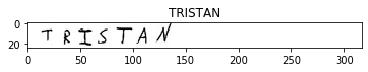

Accuracy: 0.8157849089332176


In [23]:
plt.title(labels[7])
plt.imshow(x_test[7], cmap=plt.cm.gray)
plt.show()

#This accuracy function evaluates the accuracy on character predition, 
# not on full-name prediction

print("Accuracy:",accuracy(y_test, labels)) 